In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random as rd

### EDA

In [2]:
iris = pd.read_csv('IRIS.csv')

In [3]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
iris.species.unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

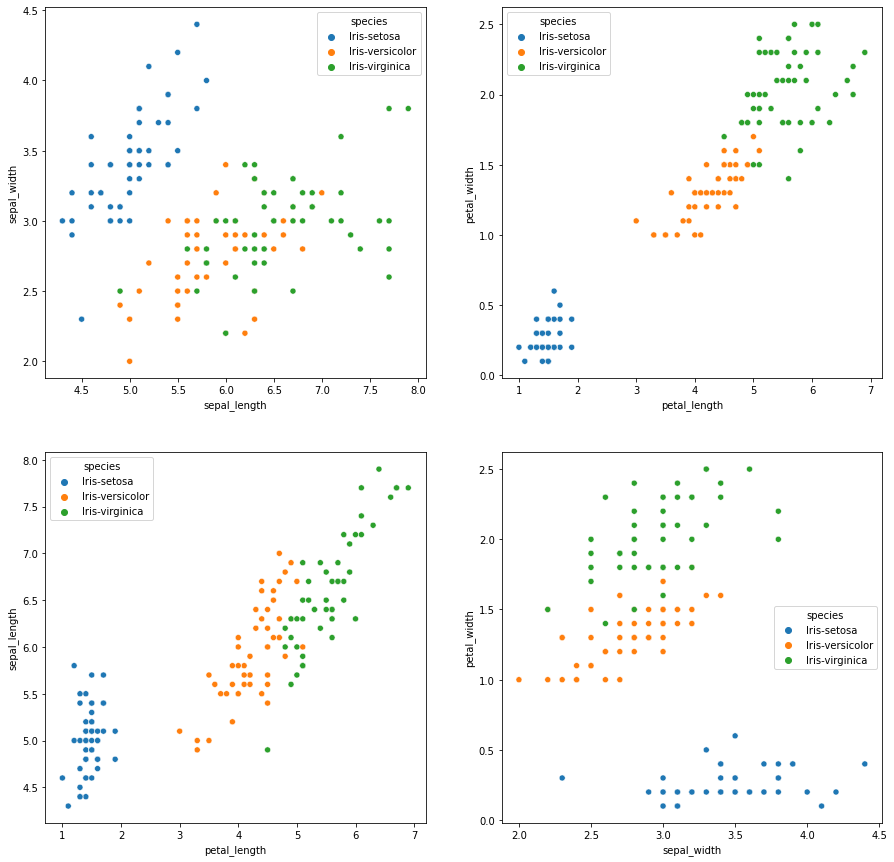

In [23]:
fig, axs = plt.subplots(figsize=(15,15),ncols=2, nrows=2)

sns.scatterplot(x='sepal_length', y='sepal_width', data=iris, hue=iris.species, ax=axs[0][0])
sns.scatterplot(x='petal_length', y='petal_width', data=iris, hue=iris.species, ax=axs[0][1])
sns.scatterplot(x='petal_length', y='sepal_length', data=iris, hue=iris.species, ax=axs[1][0])
sns.scatterplot(x='sepal_width', y='petal_width', data=iris, hue=iris.species, ax=axs[1][1])
plt.show()

## Now the neural network

### Ill write classes for the nodes and the NN, uisng relu activation for all layers, then applying softmax to the results

In [2026]:
class Neuron:
    # flag for input neurons
    is_input = False
    a = -1
    def __init__(self, prev_list):
        # get nodes leading into this node and their weights
        self.prev_list = prev_list
        self.prev_w = np.array([])
        self.b = 0
        for n in prev_list:
            self.prev_w = np.append(self.prev_w, rd.uniform(0,0.5))
        
        # check if neuron in input neuron
        if len(prev_list)==0:
            self.is_input = True
    
    # recursive forward propagation function
    def forward_prop(self, input_vals):
        if self.prev_list[0].is_input:
            self.a = (np.array(input_vals)*self.prev_w).sum()+self.b
            return self.a
        else:
            prev_layer = np.array([x.forward_prop(input_vals) for x in self.prev_list])
            self.a = (prev_layer*self.prev_w).sum()+self.b
            return self.a

class Neuron_relu(Neuron):
    # recursive forward propagation function with ReLu
    def forward_prop(self, input_vals):
        if self.prev_list[0].is_input:
            self.a = self.relu(np.array(input_vals)*self.prev_w).sum()+self.b
            return self.a
        else:
            prev_layer = np.array([x.forward_prop(input_vals) for x in self.prev_list])
            self.a = self.relu((prev_layer*self.prev_w).sum()+self.b)
            return self.a
    
    def relu(self, x):
        return (x>0)*x
    
    def d_relu(self, x):
        return 1*(x>0)

In [2041]:
class NN:
    def __init__(self, n_layers, layer_size):
        # create the neural network
        self.n_layers = n_layers
        self.layers = []
        self.layer_size = layer_size
        for i in range(n_layers):
            self.layers.append([])
            for j in range(layer_size[i]):
                if i == 0:
                    prev = []
                else:
                    prev = self.layers[i-1]
                
                if i == n_layers-1:
                    self.layers[i].append(Neuron(prev))
                else:
                    self.layers[i].append(Neuron_relu(prev))
    
    # softmax function for the result layer
    def softmax(self, x):
        y = x-x.max()
        return np.exp(y)/sum(np.exp(y))
    
    def d_softmax(self, x, ans):
        return -1*ans*np.power(x,-1)
    # propagate forward and apply softmax to the result
    def predict(self, inputs):
        result = np.array([x.forward_prop(inputs) for x in self.layers[self.n_layers-1]])
        return np.round(self.softmax(result),3)
    
    # find the gradients for CE
    def grad_wb(self, inputs, ans):
        w = []
        b = []
        a = []
        outs = [x.forward_prop(inputs) for x in self.layers[self.n_layers-1]]
        for i in range(self.n_layers):
            a.append(np.array([n.a for n in self.layers[i]]))
            if i>0:
                w.append(np.array([n.prev_w for n in self.layers[i]]))
                b.append(np.array([n.b for n in self.layers[i]]))
            if i==(self.n_layers-1):
                a[i] = self.softmax(a[i])
        
        delt = []
        for i in range(self.n_layers-1, 0, -1):
            if i==self.n_layers-1:
                d = []
                for j in range(len(ans)):
                    if ans[j]==0:
                        d.append(a[i][j])
                    else:
                        d.append(a[i][j]-1)
                delt.append(np.array(d))
            else:
                delt.append(np.array([ (delt[self.n_layers-1-i-1]*np.array([w[i][k][j] for k in range(self.layer_size[i+1])])*a[i][j]*(1-a[i][j])).sum() for j in range(self.layer_size[i])]))
        
        rdelt = [delt[len(delt)-i-1] for i in range(len(delt))]
        grad_w = [x.copy() for x in w]
        grad_b = [x.copy() for x in b]
        
        for i in range(self.n_layers-1, 0, -1):
            grad_b[i-1] = rdelt[i-1]
            for k in range(self.layer_size[i]):
                grad_w[i-1][k] = rdelt[i-1][k]*a[i-1]
        
        #for i in w:
        #    print(i)
        return [grad_w, grad_b, a, w]
    
    # use the gradients for training
    def train(self, inputs, outputs, lr=0.1, itterations=10):
        if not len(inputs)==len(outputs): 
            print("Amount of inputs and outputs need to match!")
            return 0
        
        step = itterations//10
        for it in range(itterations):
            if it>=10 and it%step==0:
                print("training is {p}% complete!".format(p = 10*it//step))
            curr_diff_w = -1
            curr_diff_b = -1
            
            for h in range(len(inputs)):
                curr_inp = inputs[h]
                curr_out = outputs[h]
                grads = self.grad_wb(curr_inp, curr_out)
                
                grad_w = grads[0]
                grad_b = grads[1]
                
                if h==0:
                    curr_diff_w = [x.copy() for x in grad_w]
                    for l in range(len(grad_w)):
                        curr_diff_w[l] *= 0
                    
                    curr_diff_b = [x.copy() for x in grad_b]
                    for l in range(len(grad_b)):
                        curr_diff_b[l] *= 0
                
                for l in range(len(grad_w)):
                    curr_diff_w[l] += grad_w[l]*lr
                    curr_diff_b[l] += grad_b[l]*lr
            
            for l in range(len(grad_w)):
                curr_diff_w[l] /= len(inputs)
                curr_diff_b[l] /= len(inputs)
            
                for i in range(self.layer_size[l+1]):
                    self.layers[l+1][i].b -= curr_diff_b[l][i]
                    self.layers[l+1][i].prev_w -= curr_diff_w[l][i]
        print("Done!")

In [2042]:
model = NN(4, [2,3,3,3])

In [2043]:
model.predict([0.1,0.2])

array([0.329, 0.337, 0.334])

In [2044]:
model.grad_wb(np.array([0.1,0.2]), [1,0,0])

[[array([[-6.51181075e-05, -6.51181075e-05],
         [-4.68436086e-04, -4.68436086e-04],
         [-2.12904305e-04, -2.12904305e-04]]),
  array([[0.00010648, 0.00012092, 0.0001317 ],
         [0.00074996, 0.00085163, 0.00092757],
         [0.00016313, 0.00018524, 0.00020176]]),
  array([[-0.04224911, -0.04177076, -0.0599368 ],
         [ 0.02123324,  0.02099284,  0.03012259],
         [ 0.02101587,  0.02077792,  0.02981421]])],
 [array([6.51181075e-05, 4.68436086e-04, 2.12904305e-04]),
  array([0.00129237, 0.00910239, 0.00197989]),
  array([-0.67104034,  0.33724646,  0.33379388])],
 [array([-1, -1]),
  array([0.08239144, 0.09356144, 0.10190371]),
  array([0.06296061, 0.06224776, 0.08931921]),
  array([0.32895966, 0.33724646, 0.33379388])],
 [array([[0.20951754, 0.30719844],
         [0.0087914 , 0.46341151],
         [0.14615789, 0.4364396 ]]),
  array([[0.12494446, 0.30715767, 0.23481126],
         [0.02723055, 0.49106574, 0.13796726],
         [0.22828433, 0.33167161, 0.3874134 ]]),

## Training and testing the model

In [1992]:
from sklearn.model_selection import train_test_split

In [1993]:
df = iris[['petal_length', 'petal_width', 'species']]
#df = df[df.species!='Iris-versicolor']
train, test = train_test_split(df, test_size=0.2)

In [1994]:
train

,petal_length,petal_width,species
88,4.1,1.3,Iris-versicolor
132,5.6,2.2,Iris-virginica
120,5.7,2.3,Iris-virginica
22,1.0,0.2,Iris-setosa
36,1.3,0.2,Iris-setosa
...,...,...,...
147,5.2,2.0,Iris-virginica
98,3.0,1.1,Iris-versicolor
31,1.5,0.4,Iris-setosa
108,5.8,1.8,Iris-virginica


In [1995]:
train.species.value_counts()

Iris-virginica     41
Iris-setosa        41
Iris-versicolor    38
Name: species, dtype: int64

In [1996]:
train_inp = train.iloc[:,:2].values
train_inp[:6]

array([[4.1, 1.3],
       [5.6, 2.2],
       [5.7, 2.3],
       [1. , 0.2],
       [1.3, 0.2],
       [1.2, 0.2]])

In [1997]:
rspec = {0:'Iris-setosa', 1:'Iris-versicolor', 2:'Iris-virginica'}

In [1998]:
spec = {'Iris-setosa':np.array([1,0,0]), 'Iris-versicolor':np.array([0,1,0]), 'Iris-virginica':np.array([0,0,1])}

train_out = [spec[i] for i in train.iloc[:,2].values]
train_out[:6]

[array([0, 1, 0]),
 array([0, 0, 1]),
 array([0, 0, 1]),
 array([1, 0, 0]),
 array([1, 0, 0]),
 array([1, 0, 0])]

In [2045]:
model = NN(5, [2,3,3,3,3])

In [2047]:
model.train(train_inp, train_out, lr=0.1, itterations=1000)

training is 10% complete!
training is 20% complete!
training is 30% complete!
training is 40% complete!
training is 50% complete!
training is 60% complete!
training is 70% complete!
training is 80% complete!
training is 90% complete!
Done!


In [2048]:
model.grad_wb(np.array([6,2.5]), [0,0,1])

[[array([[-0.00012323, -0.00012323],
         [-0.00392197, -0.00392197],
         [-0.00166916, -0.00166916]]),
  array([[-0.00141471, -0.00282614, -0.00304553],
         [-0.00189345, -0.0037825 , -0.00407613],
         [-0.00180411, -0.00360402, -0.00388379]]),
  array([[ 0.00687429,  0.00645142,  0.00679908],
         [-0.02172909, -0.02039243, -0.02149137],
         [ 0.00168841,  0.00158455,  0.00166994]]),
  array([[ 0.00022502,  0.00019781,  0.00021605],
         [ 0.14159962,  0.12447334,  0.13595225],
         [-0.14182464, -0.12467115, -0.13616829]])],
 [array([0.00012323, 0.00392197, 0.00166916]),
  array([-0.00105287, -0.00140916, -0.00134267]),
  array([ 0.00808556, -0.02555782,  0.00198591]),
  array([ 0.00021386,  0.13457303, -0.13478688])],
 [array([-1, -1]),
  array([1.34367461, 2.68422763, 2.89259722]),
  array([0.85019358, 0.79789396, 0.840892  ]),
  array([1.05221399, 0.92495014, 1.01024886]),
  array([2.13855947e-04, 1.34573026e-01, 8.65213118e-01])],
 [array([[0.

In [2049]:
model.predict([1.9,0.4])

array([0.843, 0.15 , 0.007])

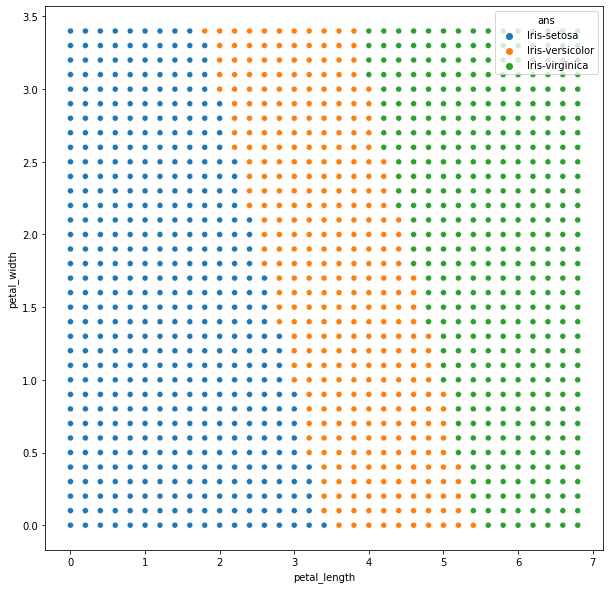

In [2050]:
X,Y = np.mgrid[0:7:0.2, 0:3.5:0.1]
xy = np.vstack((X.flatten(), Y.flatten()))

ans = []
for i in range(len(xy[0])):
    ans.append(rspec[np.argmax(model.predict([xy[0][i], xy[1][i]]))])

ans = pd.Series(ans)
x = pd.Series(xy[0])
y = pd.Series(xy[1])

visdf = pd.DataFrame({'ans':ans, 'petal_length':x, 'petal_width':y})

plt.figure(figsize=(10,10))
sns.scatterplot(x='petal_length', y='petal_width', data=visdf, hue=visdf.ans)
plt.show()

## Trained the model, now to see how it does on the test data

In [2051]:
test = test.reset_index().drop(columns='index')
test.head()

,petal_length,petal_width,species
0,5.1,1.9,Iris-virginica
1,1.3,0.3,Iris-setosa
2,4.0,1.2,Iris-versicolor
3,4.6,1.5,Iris-versicolor
4,6.3,1.8,Iris-virginica


In [2052]:
a = []
for i in test.index:
    a.append(rspec[np.argmax(model.predict([test.loc[i, "petal_length"], test.loc[i, "petal_width"]]))])
    
test['predicted'] = pd.Series(a)

<AxesSubplot: xlabel='petal_length', ylabel='petal_width'>

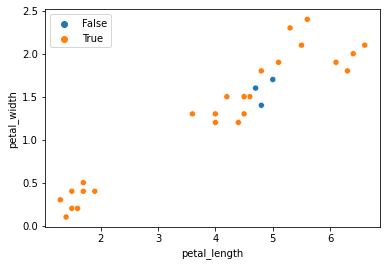

In [2053]:
sns.scatterplot(x='petal_length', y='petal_width', data=test, hue=test.species==test.predicted)

In [2054]:
print("Accuracy: {acc}".format(acc = (test.species==test.predicted).sum()/len(test)))

Accuracy: 0.9


## The Accuracy of our trained model is 90%